In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams
import matplotlib.pyplot as plt

folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"

# Load data

In [2]:
# Read in the data
adata = sc.read(folder_path + "adata_scVI.h5ad")
# adata = sc.read(folder_path + 'adata_annotated.h5ad')
# model = scvi.model.SCVI.load(folder_path + "model/", adata)

In [3]:
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

c:\Users\heung\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

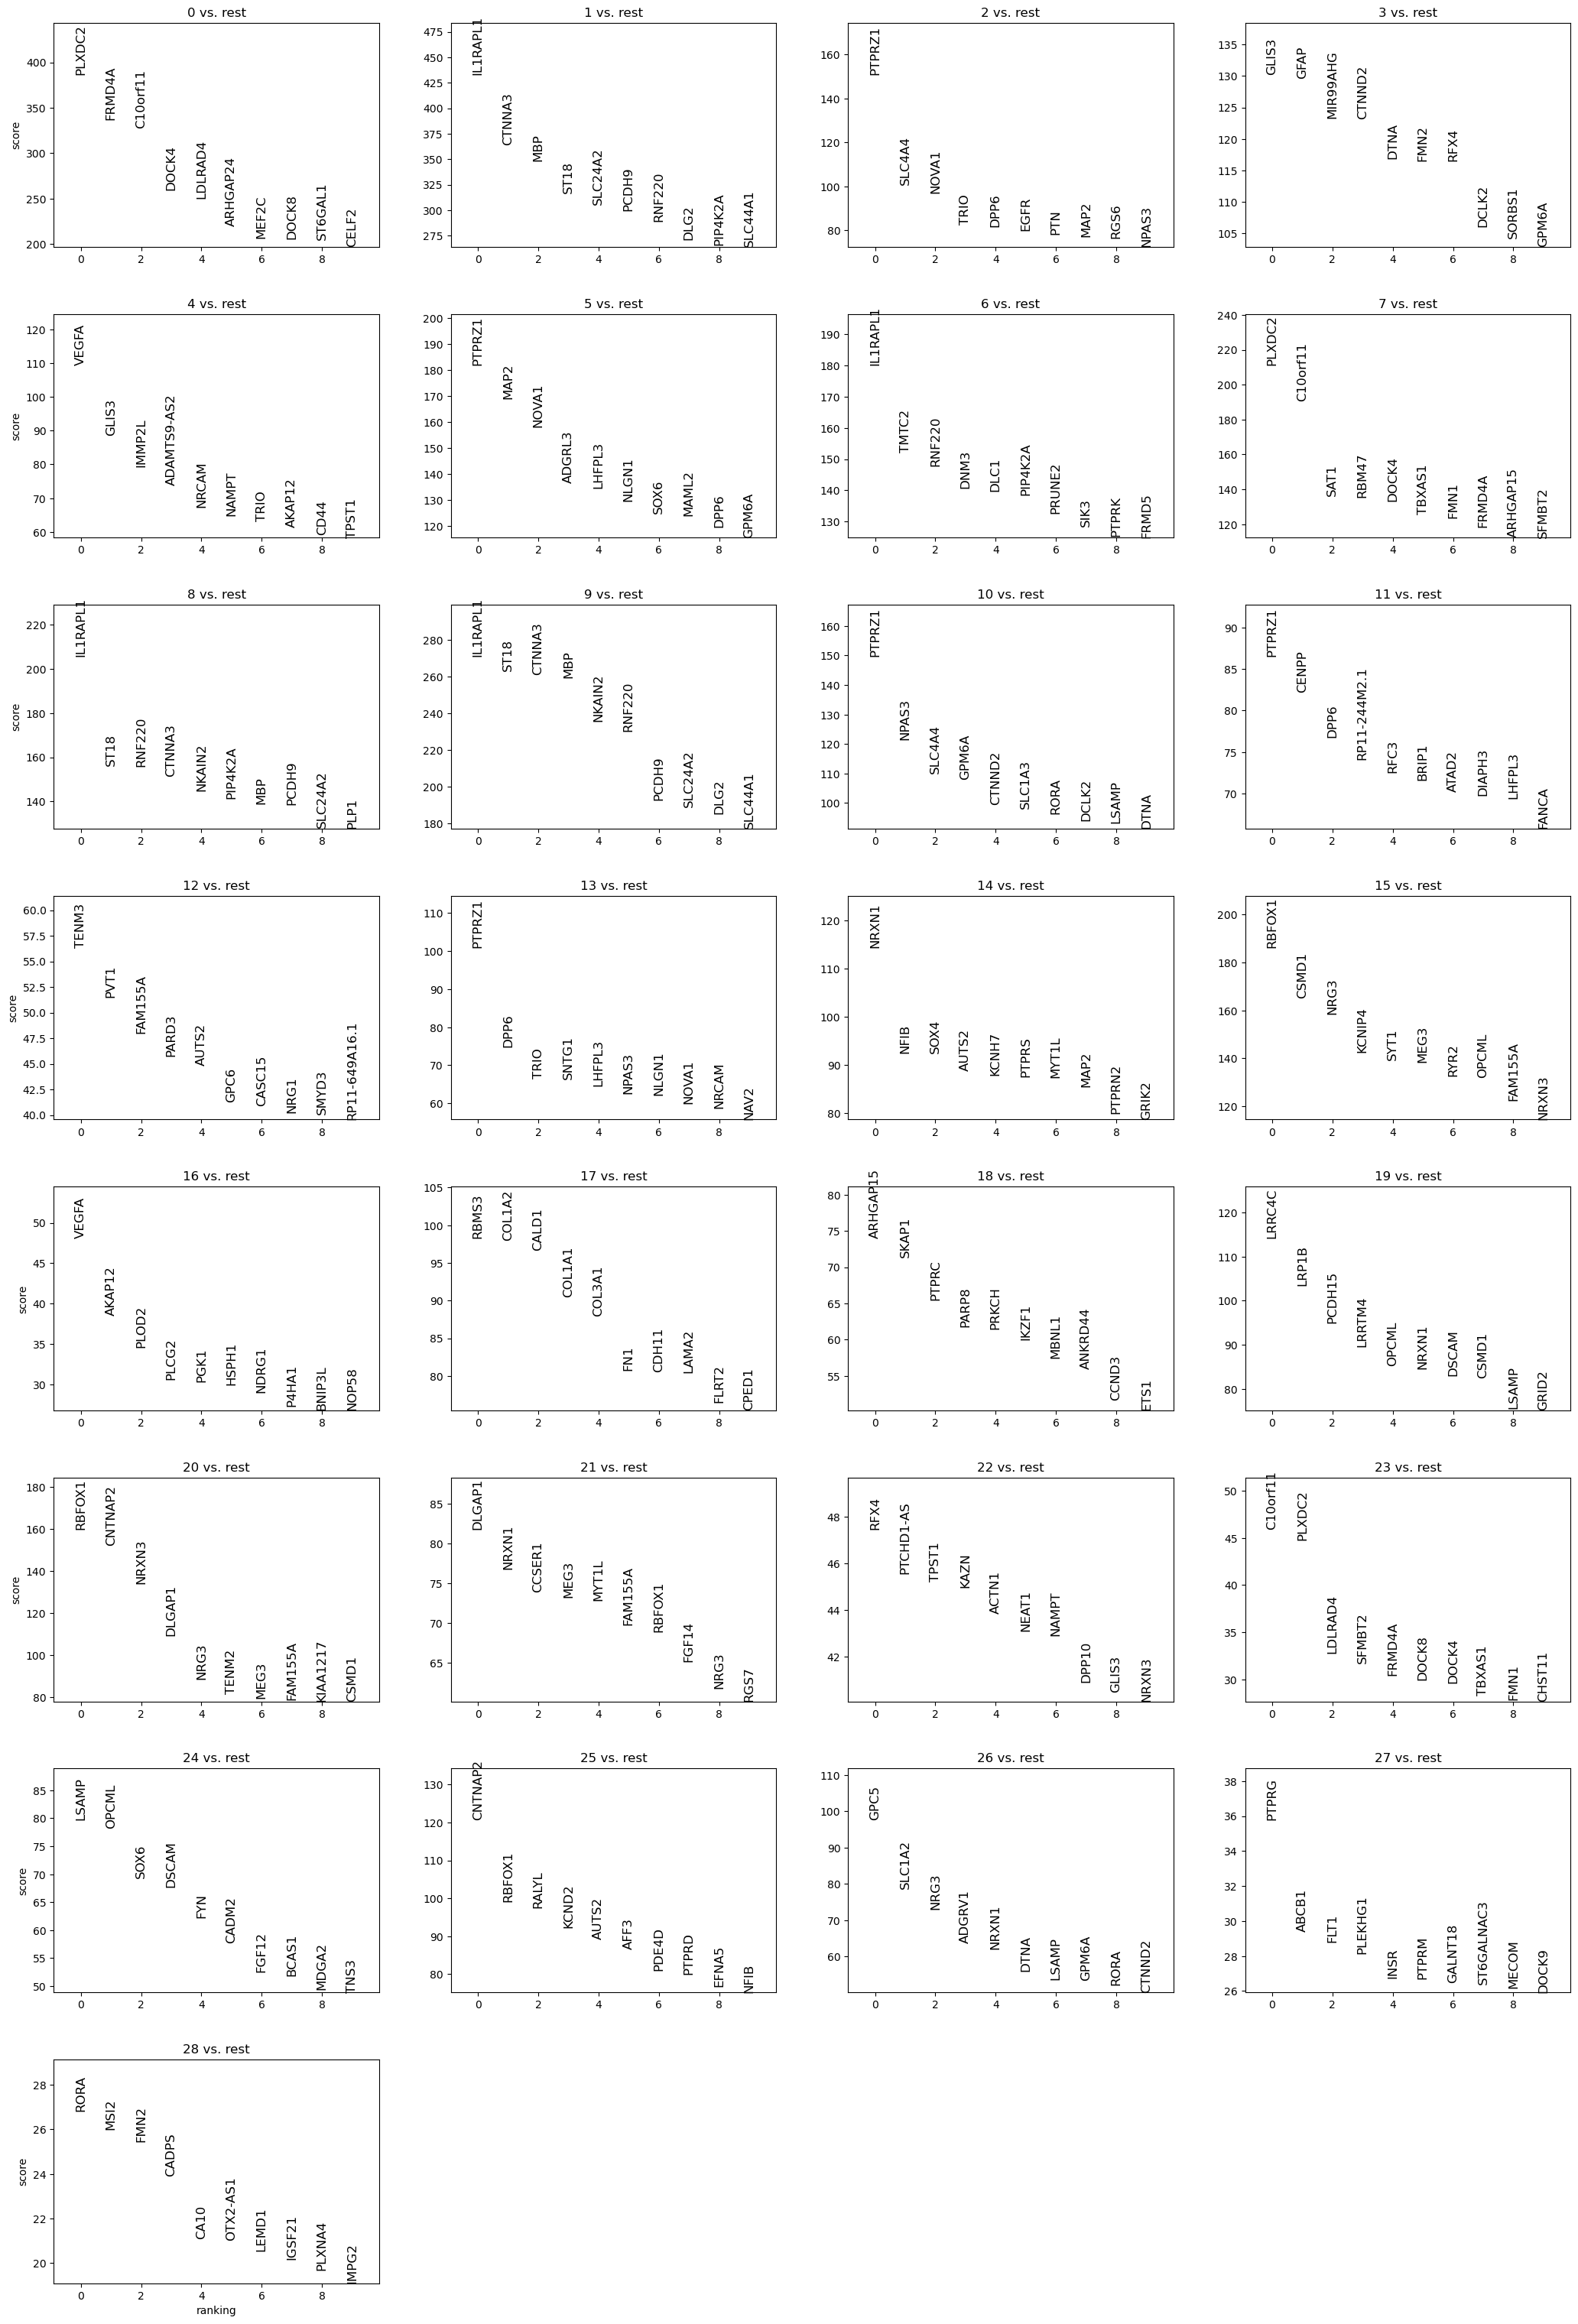

In [4]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes = 10, sharey = False, fontsize = 12)

# run time: 27s
# run time: 39s for adata_harmony.h5ad

# Finding markers

In [5]:
# making markers
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]

In [ ]:
# making markers_scvi
# 18개 cluster DEG 찾는데 약 3분 소요
# 94개 sample 찾는데 1시간 반 걸림 -> 안돌림.
markers_scvi = model.differential_expression(groupby = 'leiden')

# markers_scvi filtering
# FDR < 0.05 and logFC > 0.5
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

FDR (false discovery rate)\
FDR < 0.005 :위양성의 비율이 0.05 미만이다.\
LFC: log fold change

# Visualizing UMAP cluster

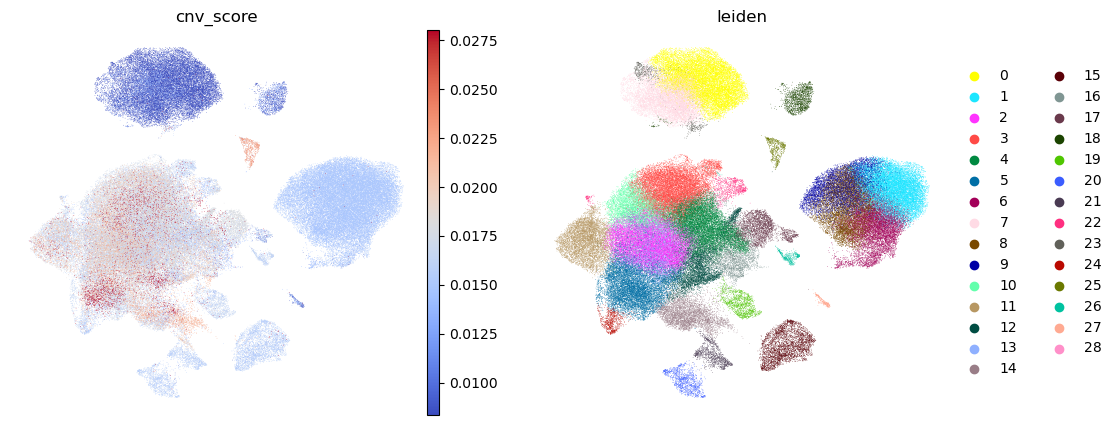

In [6]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    # color = ['leiden', 'sample', 'cnv_score'],
    color = ['cnv_score', 'leiden'],
    frameon = False,
    # legend_loc = 'on data',
    color_map = 'coolwarm'
)

# Cell type annotation

In [ ]:
for i in range(29):
    print(f'"{i}": "", ')

In [43]:
cell_type = {
    "0": "Monocytic cells", 
    "1": "Oligodendrocytes", 
    "2": "Malignant cells", 
    "3": "Malignant cells", 
    "4": "Malignant cells", 
    "5": "Malignant cells", 
    "6": "Oligodendrocytes", 
    "7": "Monocytic cells", 
    "8": "Oligodendrocytes", 
    "9": "Oligodendrocytes", 
    "10": "Malignant cells", 
    "11": "Malignant cells", 
    "12": "Malignant cells", 
    "13": "Malignant cells", 
    "14": "Malignant cells", 
    "15": "Neurons", 
    "16": "Malignant cells", 
    "17": "Fibroblasts", 
    "18": "T cells", 
    "19": "Fibroblasts", 
    "20": "Neurons", 
    "21": "Neurons", 
    "22": "Malignant cells", 
    "23": "Monocytic cells", 
    "24": "Malignant cells", 
    "25": "Malignant cells", 
    "26": "Astrocytes", # SLC1A2 
    "27": "Endothelial cells", 
    "28": "Malignant cells",
}

## Gene expression in feature plot

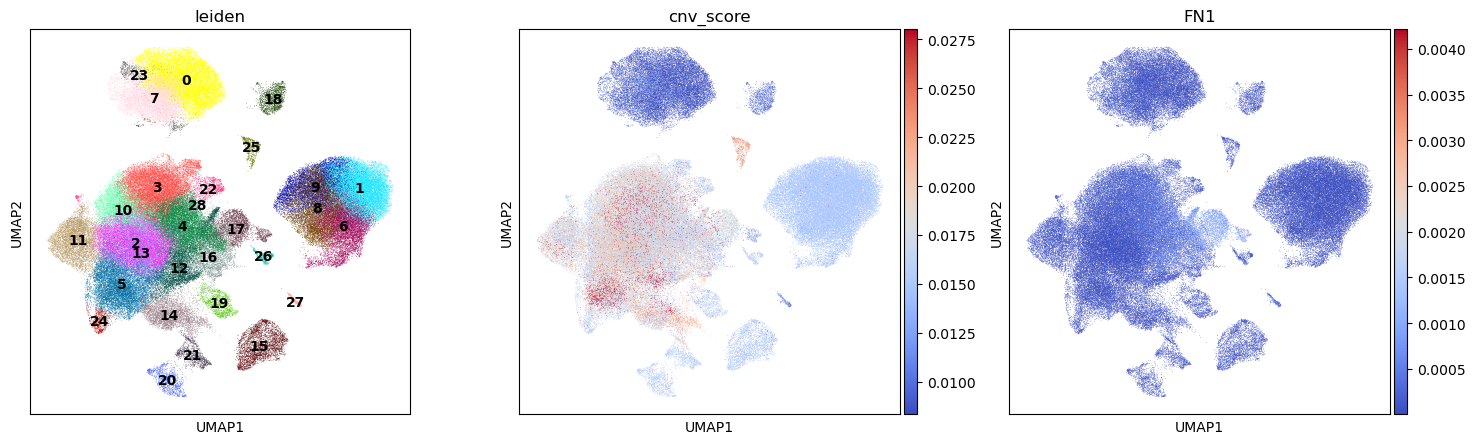

In [34]:
rcParams['figure.figsize'] = (5, 5)

sc.pl.umap(
    adata,
    color = ['leiden', 'cnv_score', 'FN1'],
    # frameon = False,
    layer = 'scvi_normalized',
    color_map = 'coolwarm',
    legend_loc = 'on data',
)

In [ ]:
adata.obs.head()

## Gene expression by violin plot

In [ ]:
fig, ax = plt.subplots(figsize = (16, 4))

sc.pl.violin(
    adata,
    keys = ['SYP'],
    groupby = 'leiden',
    stripplot = False,
    # jitter = 0.4,
    # size = 0.3,
    layer = 'scvi_normalized', use_raw = False,
    ax = ax,
)

## Search cluster by gene name

In [ ]:
# 유전자를 입력하면 높게 발현하는 cluster를 보여줌
markers[markers.names == 'P2ry12']

## Search genes highly expressed in the cluster

In [ ]:
# cluster를 입력하면 높게 발현하는 유전자를 보여줌
for item in markers_scvi[markers_scvi.group1 == '15'][0:10].index:   # 10 개 까지 보여줌
    print(item)

## Cell type 설정

In [48]:
# Assigning cell types
# adata obs에 cell_type column 추가
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)
adata.obs.head(5)

# Monocytic cells 중 P2RY12 발현이 0 초과인 cell들을 Microglia로 변경
monocytic_cells = adata.obs['cell_type'] == 'Monocytic cells'
p2ry12_positive = adata[:, 'P2RY12'].to_df().iloc[:, 0] > 0

# adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['Microglia'])
adata.obs.loc[monocytic_cells & p2ry12_positive, 'cell_type'] = 'Microglia'

## Cell type 확인

### UMAP 확인

In [ ]:
adata

In [53]:
# https://colorswall.com/palette/68
colors = ['#f44336', '#9c27b0', '#3f51b5', '#2196f3', '#009688', '#8bc34a', '#ffc107', '#ff9800', '#795548', '#607d8b']
# colors = colors[::-1]
adata.uns['cell_type_colors'] = colors

In [57]:
import pandas as pd

desired_order = ['Malignant cells', 'Monocytic cells', 'Microglia', 'T cells', 'Oligodendrocytes', 'Astrocytes', 'Neurons', 'Endothelial cells', 'Fibroblasts']
adata.obs['cell_type'] = pd.Categorical(
    values = adata.obs.cell_type, categories = desired_order, ordered = True
)

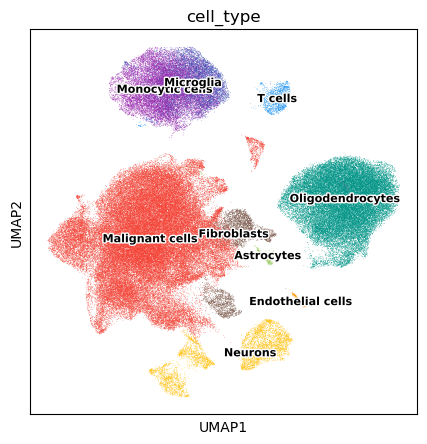

In [59]:
rcParams['figure.figsize'] = (5, 5)
sc.pl.umap(
    adata,
    color = ['cell_type'],
    # frameon = False,
    legend_loc = 'on data',
    legend_fontsize = 8,
    legend_fontoutline = 2,
)

### Violin plot gene expression 확인

In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))

sc.pl.violin(
    adata,
    keys = ['C10orf54'],
    groupby = 'cell_type',
    stripplot = False,
    # jitter = 0.4,
    # size = 0.3,
    layer = 'scvi_normalized', use_raw = False,
    ax = ax,
    show = False
)

plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right')   # x 축 레이블 회전
plt.show()

### Dot plot

In [67]:
marker_genes_dict = {
    'Malignant cells': ['EGFR'],
    'Monocytic cells': ['HLA-DRA'],
    'Microglia': ['P2RY12'],

    'T cells': ['CD3E'],
    'Oligodendrocytes': ['MBP'],
    'Astrocytes': ['SLC1A2'],
    'Neurons': ['SNAP25'],
    'Endothelial cells': ['ESAM'],
    'Fibroblasts': ['FN1'],

}

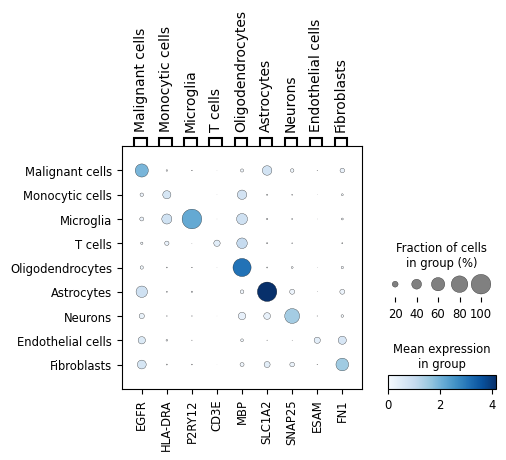

In [70]:
# sc.tl.dendrogram(adata, groupby = 'cell_type')    # dot plot 한번 그린 후 cell type annotation 바꾸면 이거 돌려줘야 함

sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby = 'cell_type',
    # dendrogram = True,
    # var_group_rotation = 45,
    cmap = 'Blues',
    # use_raw = False, layer = 'scvi_normalized',
)

In [ ]:
adata

# Save

In [71]:
# adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

adata.write_h5ad(folder_path + "adata_annotated.h5ad")
# 3,446,216 kb